<a href="https://colab.research.google.com/github/moeinghaeini/Audio-Pattern-Recognition/blob/main/Genre_Classifier_%2B_KMeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import json
import os
import math
import librosa
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DATASET_PATH = "/content/drive/MyDrive/University of Milan/Audio Pattern Recognition/Dataset/genres_original"
JSON_PATH = "/content/drive/MyDrive/University of Milan/Audio Pattern Recognition/Data_kmeans.json"
SAMPLE_RATE = 22050
TRACK_DURATION = 30  # measured in seconds (Each track in our dataset is 30 seconds)
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION
NUM_CLUSTERS = 10  # Number of clusters for K-Means (Default 10 for GTZAN)

def save_mfcc(dataset_path, json_path, num_mfcc=13, n_fft=2048, hop_length=512, num_segments=5):
    """Extracts MFCCs from music dataset and saves them into a json file along with genre labels.
        :param dataset_path (str): Path to dataset
        :param json_path (str): Path to json file used to save MFCCs
        :param num_mfcc (int): Number of coefficients to extract
        :param n_fft (int): Interval we consider to apply FFT. Measured in # of samples
        :param hop_length (int): Sliding window for FFT. Measured in # of samples
        :param: num_segments (int): Number of segments we want to divide sample tracks into. => To increase the number of training tracks.
        :return:
    """

    # dictionary to store mapping, labels, and MFCCs
    data = {
        "mapping": [],  #for example: list:["classical","blues",...] => classical is mappied to 0 and blues to 1. => each genre is mapped to its coresponding index in the list.
        "labels": [], #These are the outputs => is a list : [0, 1, 0] => it is coresponding results to the below list of MFCCs => it says that the first list of MFCCs is classical.
        "mfcc": [],  #These are the inputs => is a list : [[...], [...], [...], ... ] , # Added a comma here
        "clusters": []  # Stores cluster labels assigned by K-Means
    }

    samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)  # ceil function: round the number to its higher integer: (1.2 => 2)

    all_mfccs = []  # Collect all MFCCs before clustering
    all_labels = []  # Store actual genre labels

    # **********At the end of this "for" loop, we are gonna have all the ganres ("mapping" variable), also the MFCCs for each segment, and the labels for each segments.
    # loop through all genre sub-folder => At each iteration of i, we are in different genre =>but=> the first iteration is for dataset_path
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):  #dirpath: current folder / dirnames: all the subfolders in current folder / filenames: all the files in current folder

        # ensure we're processing a genre sub-folder level
        if dirpath is not dataset_path:

            # save genre label (i.e., sub-folder name) in the mapping
            semantic_label = dirpath.split("/")[-1]
            data["mapping"].append(semantic_label)
            print("\nProcessing: {}".format(semantic_label))

            # process all audio files in genre sub-dir
            for f in filenames:

                # 1. load audio file
                file_path = os.path.join(dirpath, f)
                signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)

                # 2. process all segments of audio file
                for d in range(num_segments):

                    # 2.1. calculate start and finish sample for current segment
                    start = samples_per_segment * d
                    finish = start + samples_per_segment

                    # 2.2. extract mfcc *********************** #we process a slice of the signal between (start sample< <finish sample)
                    mfcc = librosa.feature.mfcc(y=signal[start:finish], sr=sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
                    mfcc = mfcc.T  # Transpose to have time-steps as rows

                    #2.3. store only mfcc feature with expected number of vectors (As some tracks may not be exactly 30 seconds => the last segment may be shorter => but we need the ones with the exact segment size.)
                    if len(mfcc) == num_mfcc_vectors_per_segment:
                        all_mfccs.append(mfcc.flatten())  # Store MFCCs for clustering
                        all_labels.append(i - 1)  # Store actual genre label
                        print("{}, segment:{}".format(file_path, d + 1))

    # Convert MFCCs to NumPy array for clustering
    all_mfccs = np.array(all_mfccs)

    # Apply K-Means clustering
    print("\nApplying K-Means Clustering...")
    kmeans = KMeans(n_clusters=NUM_CLUSTERS, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(all_mfccs)  #The MFCC features (extracted from each segment) are clustered, and the corresponding cluster label is assigned to each segment.

    # Store clustered MFCCs in JSON
    for i, mfcc in enumerate(all_mfccs):
        data["mfcc"].append(mfcc.tolist())  # Save MFCC data
        data["labels"].append(all_labels[i])  # Save actual genre label
        data["clusters"].append(int(cluster_labels[i]))  # Save K-Means cluster label

    # save data to json file
    with open(json_path, "w") as fp:
        json.dump(data, fp, indent=4)

    print("\nMFCC extraction and K-Means clustering completed. Data saved to:", json_path)


In [ ]:
if __name__ == "__main__":
  save_mfcc(DATASET_PATH, JSON_PATH, num_segments=10)

Streaming output truncated to the last 5000 lines.
/content/drive/MyDrive/University of Milan/Audio Pattern Recognition/Dataset/genres_original/rock/rock.00008.wav, segment:1
/content/drive/MyDrive/University of Milan/Audio Pattern Recognition/Dataset/genres_original/rock/rock.00008.wav, segment:2
/content/drive/MyDrive/University of Milan/Audio Pattern Recognition/Dataset/genres_original/rock/rock.00008.wav, segment:3
/content/drive/MyDrive/University of Milan/Audio Pattern Recognition/Dataset/genres_original/rock/rock.00008.wav, segment:4
/content/drive/MyDrive/University of Milan/Audio Pattern Recognition/Dataset/genres_original/rock/rock.00008.wav, segment:5
/content/drive/MyDrive/University of Milan/Audio Pattern Recognition/Dataset/genres_original/rock/rock.00008.wav, segment:6
/content/drive/MyDrive/University of Milan/Audio Pattern Recognition/Dataset/genres_original/rock/rock.00008.wav, segment:7
/content/drive/MyDrive/University of Milan/Audio Pattern Recognition/Dataset/genr

In [ ]:
import numpy as np
import json
from collections import Counter

# Analyze the purity of clusters based on genre labels.

# Load the JSON data
JSON_PATH = "/content/drive/MyDrive/University of Milan/Audio Pattern Recognition/Data_kmeans.json"

with open(JSON_PATH, "r") as fp:
    data = json.load(fp)

# Extract labels and cluster assignments
labels = np.array(data["labels"])  # Actual genre labels
clusters = np.array(data["clusters"])  # Clustered labels

# Analyze purity of each cluster
cluster_purity = {}
num_clusters = len(set(clusters))  # Get the number of unique clusters

for cluster_id in range(num_clusters):
    indices = np.where(clusters == cluster_id)[0]  # Get indices of samples in this cluster
    genre_counts = Counter(labels[indices])  # Count genre occurrences
    dominant_genre = genre_counts.most_common(1)[0]  # Get most common genre in the cluster
    purity = dominant_genre[1] / len(indices)  # Compute purity score

    cluster_purity[cluster_id] = {
        "Dominant Genre": data["mapping"][dominant_genre[0]],
        "Purity Score": purity,
        "Genre Distribution": genre_counts
    }

# Print results
for cluster_id, info in cluster_purity.items():
    print(f"Cluster {cluster_id}:")
    print(f"  - Dominant Genre: {info['Dominant Genre']}")
    print(f"  - Purity Score: {info['Purity Score']:.2f}")
    print(f"  - Genre Distribution: {info['Genre Distribution']}\n")


Cluster 0:
  - Dominant Genre: jazz
  - Purity Score: 0.27
  - Genre Distribution: Counter({np.int64(9): 209, np.int64(4): 183, np.int64(1): 145, np.int64(0): 135, np.int64(2): 45, np.int64(5): 24, np.int64(7): 11, np.int64(6): 7, np.int64(3): 3, np.int64(8): 2})

Cluster 1:
  - Dominant Genre: metal
  - Purity Score: 0.24
  - Genre Distribution: Counter({np.int64(8): 455, np.int64(5): 315, np.int64(6): 289, np.int64(0): 287, np.int64(7): 242, np.int64(1): 181, np.int64(2): 49, np.int64(4): 40, np.int64(9): 20, np.int64(3): 3})

Cluster 2:
  - Dominant Genre: metal
  - Purity Score: 0.52
  - Genre Distribution: Counter({np.int64(8): 440, np.int64(0): 115, np.int64(5): 104, np.int64(7): 85, np.int64(6): 65, np.int64(1): 34, np.int64(2): 5, np.int64(4): 1})

Cluster 3:
  - Dominant Genre: classical
  - Purity Score: 0.91
  - Genre Distribution: Counter({np.int64(4): 168, np.int64(9): 10, np.int64(1): 2, np.int64(7): 2, np.int64(0): 1, np.int64(5): 1})

Cluster 4:
  - Dominant Genre: regg

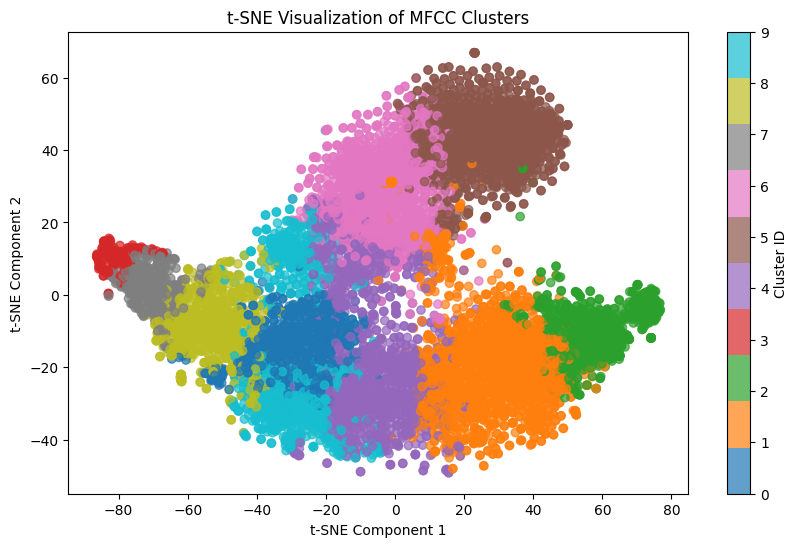

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import json
from sklearn.manifold import TSNE

# t-SNE Visualization of MFCC Clusters

# Load the JSON data
JSON_PATH = "/content/drive/MyDrive/University of Milan/Audio Pattern Recognition/Data_kmeans.json"

# Load the JSON data
with open(JSON_PATH, "r") as fp:
    data = json.load(fp)

# Extract MFCC features and cluster labels
mfccs = np.array(data["mfcc"])  # MFCC features
clusters = np.array(data["clusters"])  # Cluster labels

# Reduce MFCC dimensionality to 2D using t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
mfcc_2d = tsne.fit_transform(mfccs)

# Plot the clusters
plt.figure(figsize=(10, 6))
scatter = plt.scatter(mfcc_2d[:, 0], mfcc_2d[:, 1], c=clusters, cmap="tab10", alpha=0.7)
plt.colorbar(scatter, label="Cluster ID")
plt.title("t-SNE Visualization of MFCC Clusters")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()
